Naložimo napovedi obeh modelov in cene.

In [1]:
import pandas as pd
import pickle
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.colors as colors
import matplotlib.cm as cmx

random.seed(0)
np.random.seed(0)

with open("podatki.p", "rb") as rb:
    df = pickle.load(rb)

In [2]:
df.head()

,t,cena,napoved_30s,napoved_240s
0,1658192415000,22337.927751,-0.084562,0.271007
1,1658192445000,22319.601893,-0.173261,0.382973
2,1658192475000,22319.833136,-0.113605,0.244607
3,1658192505000,22323.233195,0.219418,0.420836
4,1658192535000,22362.738462,0.073424,0.178353


Sortiramo sezname glede na čas ('t')

In [3]:
df = df.sort_values(by='t')

Izbrišemo vrstice z manjkajočimi vrednostmi

In [4]:
df = df.dropna()

Konstante za diskretna stanja pozicij

In [5]:
POZICIJA_DOLGO = 1
POZICIJA_KRATKO = -1
POZICIJA_BREZ = 0

Vizualizacija jakosti signalov (napovedi) v kontekstu gibanja cen

/tmp/ipykernel_23348/936811789.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)
/tmp/ipykernel_23348/936811789.py:38: UserWarning: Legend does not support handles for Colorbar instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles, labels)


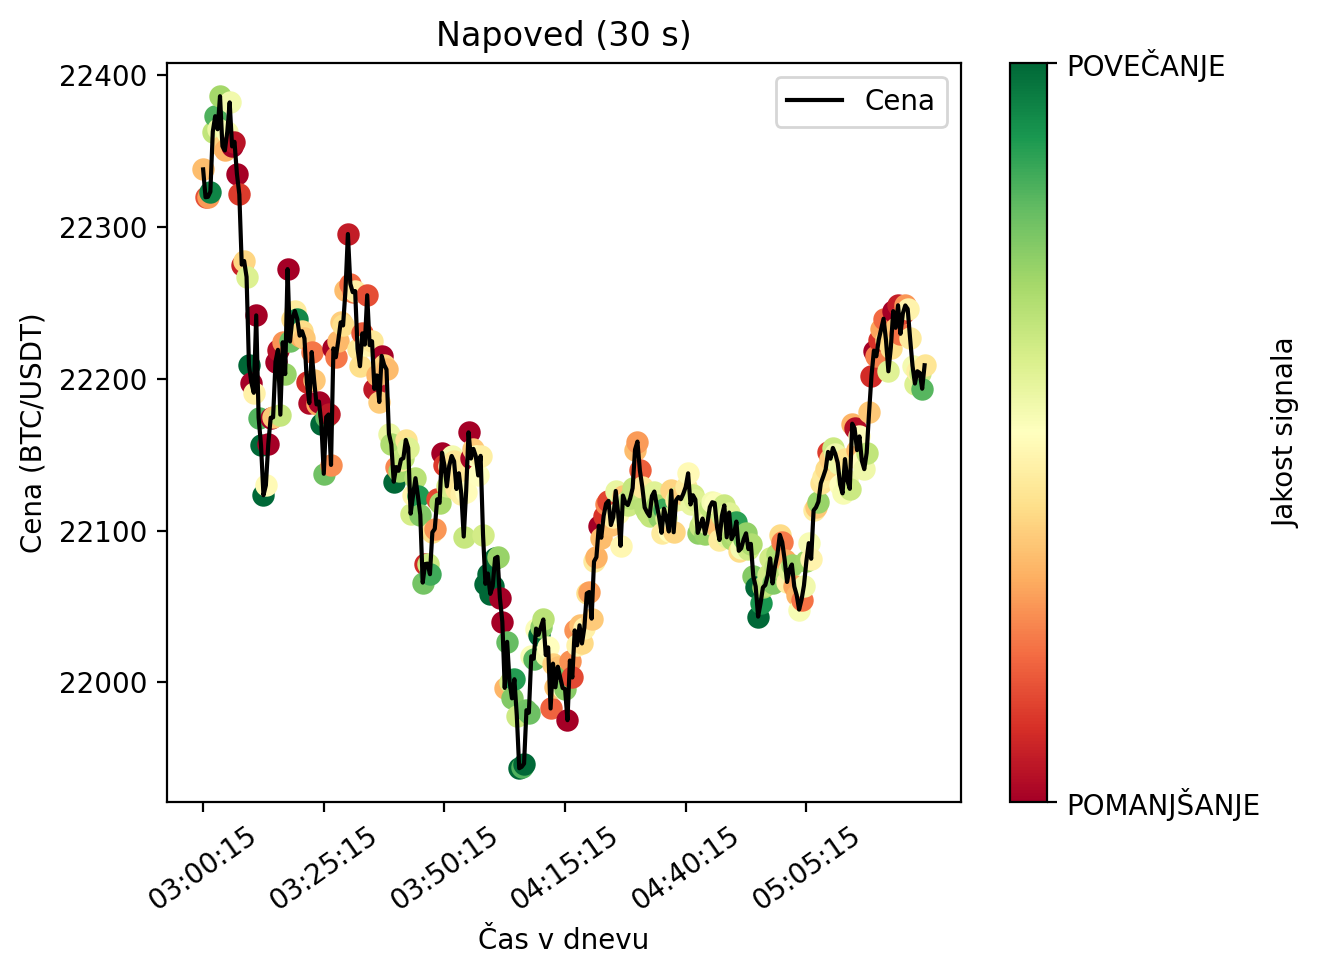

/tmp/ipykernel_23348/936811789.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)
/tmp/ipykernel_23348/936811789.py:38: UserWarning: Legend does not support handles for Colorbar instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles, labels)


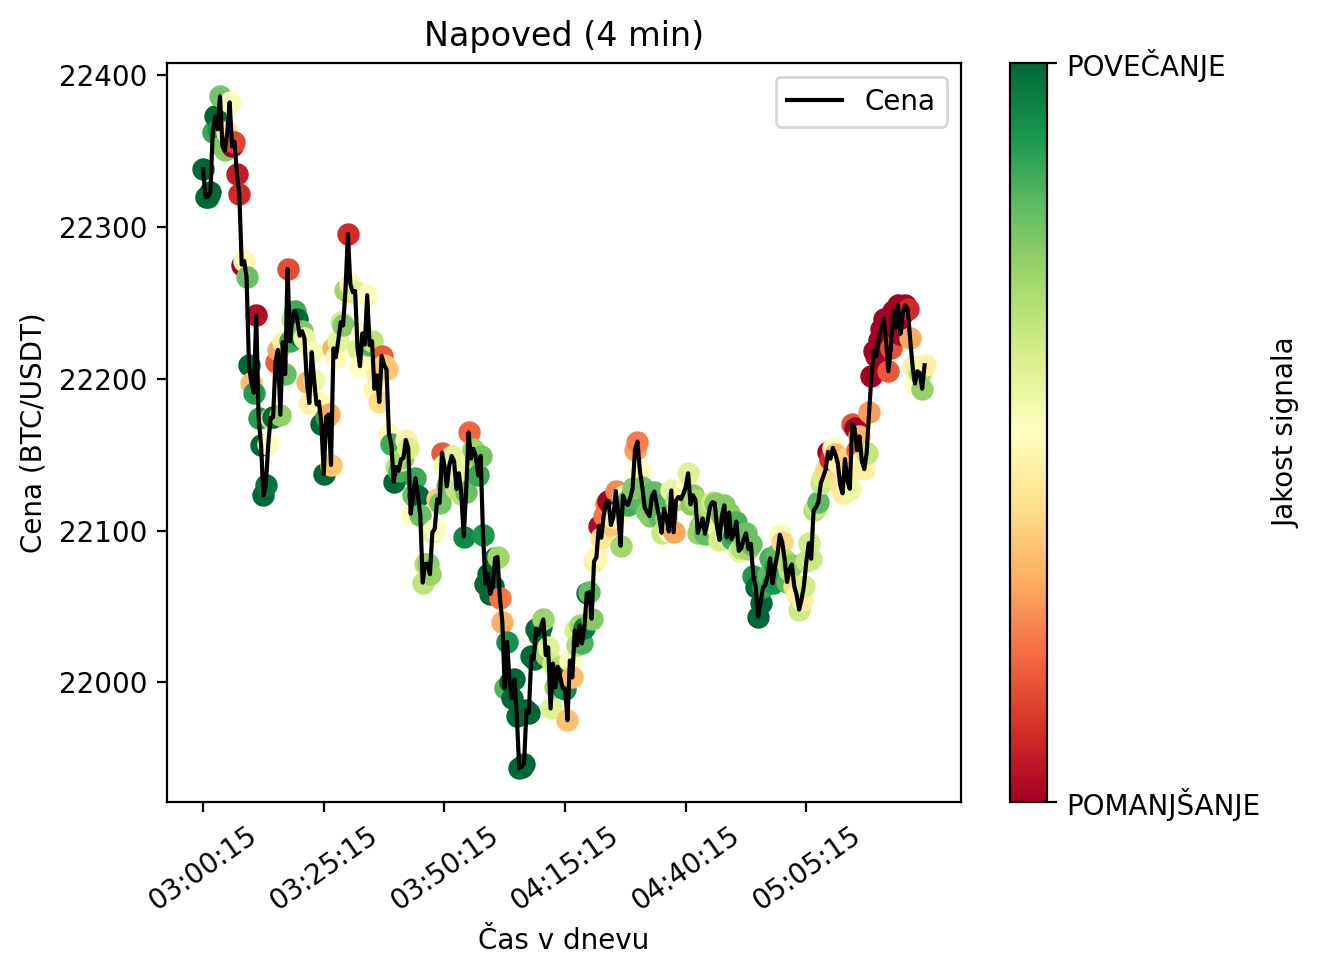

In [6]:
dolzina_segmenta = 300

cene = df["cena"].head(dolzina_segmenta).values
cas = df["t"].head(dolzina_segmenta).values

datetime_cas = [datetime.fromtimestamp(ts / 1000) for ts in cas]
formatted_cas = [dt.strftime('%H:%M:%S') for dt in datetime_cas]
x_ticks = np.arange(0, len(formatted_cas), 50)


for stolpec, ime in [("napoved_30s", "Napoved (30 s)"),("napoved_240s", "Napoved (4 min)")]:
    napovedi = df[stolpec].head(dolzina_segmenta).values

    fig, ax = plt.subplots()
    ax.set_title(ime)
    ax.plot(formatted_cas, cene, label='Cena', color="k")
    plt.xticks(rotation=35)
    ax.set_xticks(x_ticks)
    ax.set_ylabel("Cena (BTC/USDT)")
    ax.set_xlabel("Čas v dnevu")
    normalized_predictions = np.clip(napovedi, -0.5, 0.5) / 0.5 + 0.5

    cmap = cmx.ScalarMappable(colors.Normalize(vmin=0, vmax=1), plt.cm.RdYlGn)

    for i, price in enumerate(cene):
        color = cmap.to_rgba(normalized_predictions[i])
        ax.scatter(formatted_cas[i], price, color=color, s=50)

    norm = colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap.cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm)
    cbar.ax.set_yticks([0, 1], ['POMANJŠANJE','POVEČANJE'])
    cbar.set_label('Jakost signala')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(cbar)
    labels.append('Color scale')
    ax.legend(handles, labels)
    fig.set_dpi(200)

    plt.show()


Funkcija za izris grafa, ki obarva zgodovino cen glede na pozicijo

In [7]:
def narisi_zgodovino_pozicij (pozicije, cene):
    nastavitve_barv = {POZICIJA_DOLGO: 'g', POZICIJA_KRATKO: 'r', POZICIJA_BREZ: 'k'}
    crte = []
    trenutna_crta = []
    barve = []
    c = 1
    zadnja_pozicija = pozicije[0]
    while c < len(pozicije):
        trenutna_crta.append((c, cene[c]))
        if pozicije[c] != zadnja_pozicija:
            barve.append(nastavitve_barv[pozicije[c-1]])
            crte.append(trenutna_crta)
            zadnja_pozicija = pozicije[c]
            trenutna_crta = []
            c -= 1
        c += 1

    lc = LineCollection(crte, colors=barve)
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_title('Pozicije glede na čas')


Poglejmo si visualizacijo pozicij za preprosto strategijo

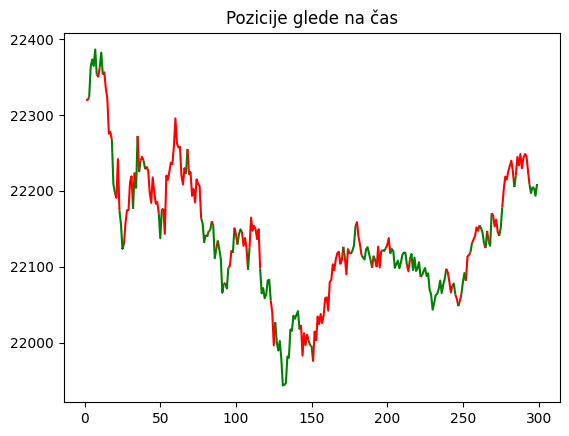

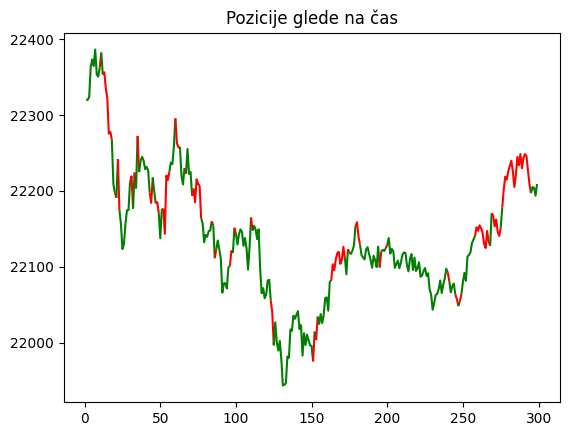

In [8]:

dolzina_segmenta = 300
cene = df["cena"].head(dolzina_segmenta).values
cas = df["t"].head(dolzina_segmenta).values
for napovedi in [ df["napoved_30s"].head(dolzina_segmenta).values, df["napoved_240s"].head(dolzina_segmenta).values]:

    zgodovina_pozicij = []
    
    for i in range(len(cene)):
        if napovedi[i] > 0:
            zgodovina_pozicij.append(POZICIJA_DOLGO)
        else:
            zgodovina_pozicij.append(POZICIJA_KRATKO)  


    narisi_zgodovino_pozicij(zgodovina_pozicij, cene)



Funkcija, ki formatira graf za prikaz rezultata simulacije

In [9]:
def narisi_graf_s_casom(cas, Y):
    datetimes = [datetime.fromtimestamp(ts/1000) for ts in cas]
    months = mdates.MonthLocator()  
    month_fmt = mdates.DateFormatter('%b')
    plt.gca().xaxis.set_major_locator(months)
    plt.gca().xaxis.set_major_formatter(month_fmt)
    #plt.plot(datetimes, Y, color = "k")
    plt.plot(datetimes, Y)

Poglejmo si grafe naših vrednosti

Text(0.5, 1.0, 'Napoved (4 min)')

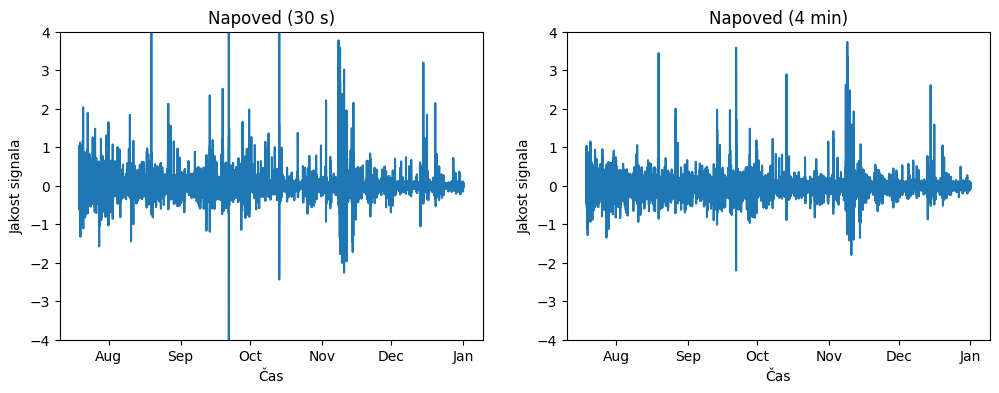

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(121)
narisi_graf_s_casom(df["t"].values, df["napoved_30s"].values)
plt.xlabel('Čas')
plt.ylabel('Jakost signala')
plt.ylim(-4, 4)
plt.title('Napoved (30 s)')

plt.subplot(122)
narisi_graf_s_casom(df["t"].values, df["napoved_240s"].values)
plt.xlabel('Čas')
plt.ylabel('Jakost signala')
plt.ylim(-4, 4)
plt.title('Napoved (4 min)')


Poglejmo si manjši interval podatkov

Text(0.5, 1.0, 'Cene')

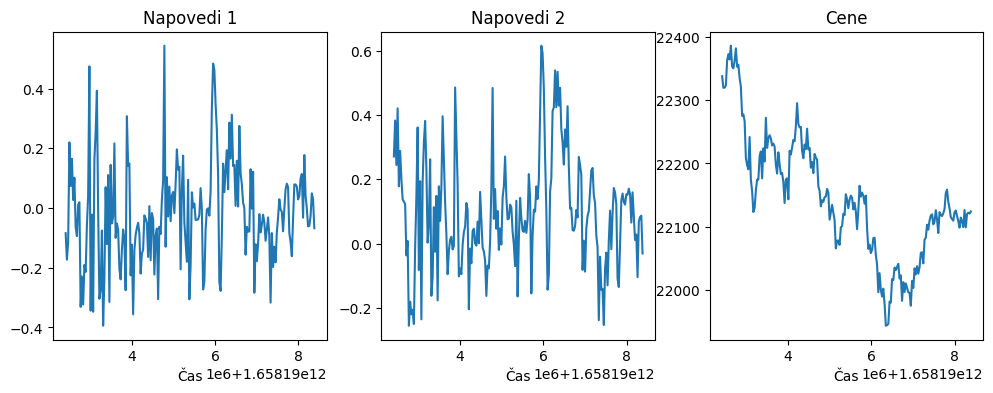

In [11]:
plt.figure(figsize=(12,4))
mini_df = df.head(200)
plt.subplot(131)
plt.plot(mini_df['t'], mini_df['napoved_30s'])
plt.xlabel('Čas')
plt.title('Napovedi 1')


plt.subplot(132)
plt.plot(mini_df['t'], mini_df['napoved_240s'])
plt.xlabel('Čas')
plt.title('Napovedi 2')

plt.subplot(133)
plt.plot(mini_df['t'], mini_df['cena'])
plt.xlabel('Čas')
plt.title('Cene')

Pripravimo konstante, ki jih bomo uporabljali v simulacijah. S stroški trgovanja upoštevamo tudi (ne-)učinkovitost likvidnosti.

In [12]:
stroski = 0.00005
velikost_pozicije = 1000

#to smo določili že v času učenja nevronskih mrež
test_start_t = 1665386325000

ucna_start_index = 0
test_start_index = list(df["t"]).index(test_start_t)

Natančneje si poglejmo tečaje učne in testne množice.

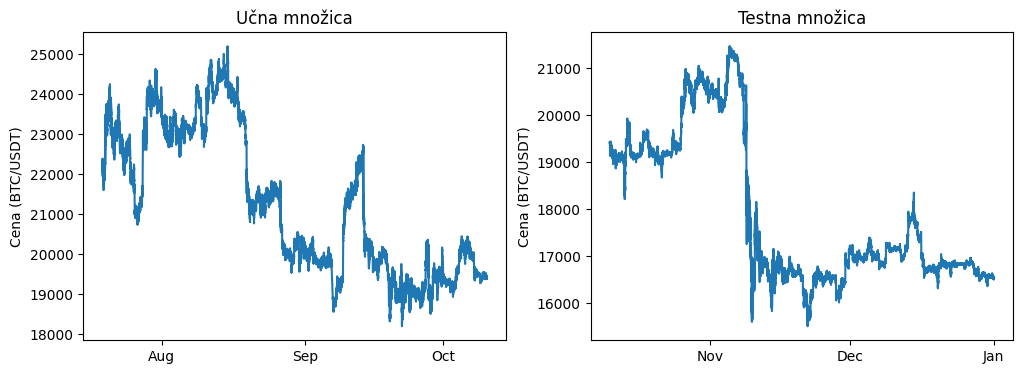

In [13]:
df_ucna = df.iloc[ucna_start_index:test_start_index]
df_testna = df.iloc[test_start_index:]

plt.figure(figsize=(12,4))

plt.subplot(121)
narisi_graf_s_casom(df_ucna["t"].values, df_ucna["cena"].values,)
plt.title("Učna množica")
plt.ylabel('Cena (BTC/USDT)')

plt.subplot(122)
narisi_graf_s_casom(df_testna["t"].values, df_testna["cena"].values)
plt.title("Testna množica")
plt.ylabel('Cena (BTC/USDT)')
plt.show()

Definiramo funkcijo simulacije, ki izračuna donos strategije trgovanja za določene parametre (vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2)

In [14]:
def simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, zacetek, konec, narisi_graf = False, show_graf=True, graf_pozicij = True):

  zgodovina = []
  zgodovina_pozicij = []
  zgodovina_cen = []
  cas = []
  donos = 0  
  pozicija = POZICIJA_BREZ
  prejsnji_t = 0
  #zankamo v zaporedju skozi cene in napovedi
  for row in df.iloc[zacetek:konec].itertuples(index=False):
    t = row.t
    cena = row.cena
    napoved_30s = row.napoved_30s
    napoved_240s = row.napoved_240s

    zgodovina_pozicij.append(pozicija)
    zgodovina_cen.append(cena)
    #če je prekinitev v podatkih, ignoriramo in resetiramo trenutno pozicijo
    if t - prejsnji_t != 30000 and t != 0:
      pozicija = POZICIJA_BREZ
    prejsnji_t = t

    if narisi_graf:
      zgodovina.append(donos)
      cas.append(t)

    if pozicija == POZICIJA_BREZ:
      if napoved_30s > vstop_model_1 and napoved_240s > vstop_model_2:
        pozicija = POZICIJA_DOLGO
        vstopna_cena = cena
      elif napoved_30s < -vstop_model_1 and napoved_240s < -vstop_model_2:
        pozicija = POZICIJA_KRATKO
        vstopna_cena = cena

    elif pozicija == POZICIJA_DOLGO:
      if napoved_30s < -izstop_model_1 and napoved_240s < -izstop_model_2:
        pozicija = POZICIJA_BREZ
        razlika = (cena - vstopna_cena)/vstopna_cena
        donos = donos + velikost_pozicije * (razlika - stroski*2)
    else:# pozicija == POZICIJA:KRATKO
      if napoved_30s > izstop_model_1 and napoved_240s > izstop_model_2:
        pozicija = POZICIJA_BREZ
        razlika = (vstopna_cena - cena)/vstopna_cena
        donos = donos + velikost_pozicije * (razlika - stroski*2)
  if narisi_graf:
    plt.ylabel("Donos (USDT)")
    plt.xlabel("Čas")
    narisi_graf_s_casom(cas, zgodovina)
    if graf_pozicij:
      narisi_zgodovino_pozicij(zgodovina_pozicij,zgodovina_cen )
    if show_graf:
      plt.show()
  return donos

Poskusimo preprosto strategijo na učni množici, kjer spreminjamo pozicijo, kadar se obe napovedi spreminjata med pozitivnimi in negativnimi vrednostmi. Večina člankov, ki izdelujejo finančne napovedovalne sisteme, uporabijo takšen pristop za testiranje modelov (ne uporabljajo optimizacije strategije trgovanja).

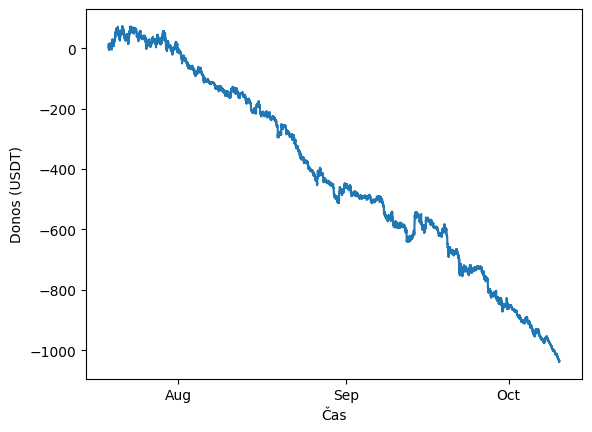

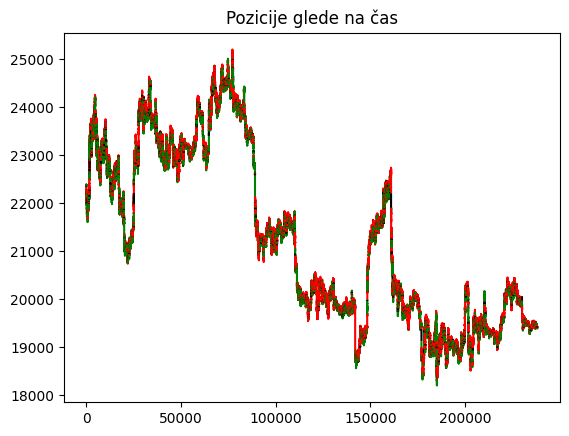

-1034.6137377082216

In [15]:
simulacija(0,0,0,0,0,test_start_index,True)

Poskusimo še enkrat isto, vendar ignoriramo stroške trgovanja.

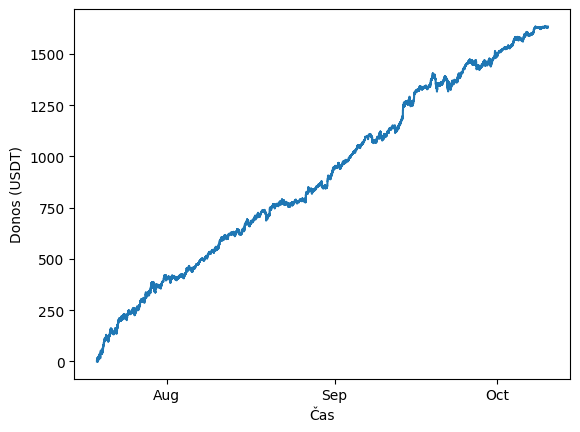

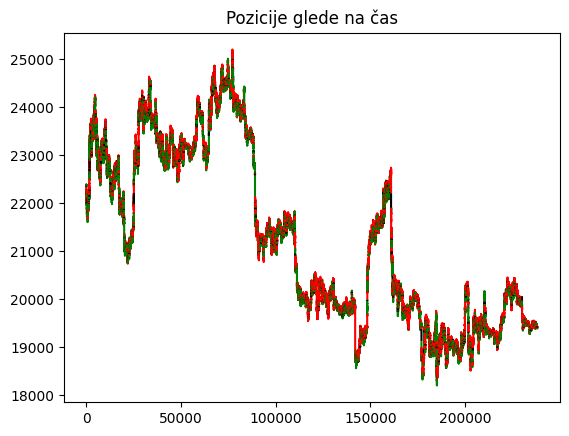

In [16]:
stroski_backup = stroski
stroski = 0
simulacija(0,0,0,0,0,test_start_index,True)
stroski = stroski_backup

Kadar upoštevamo stroške trgovanja, je rezultat je zelo slab. Poskusimo izbrati 0.95-ti kvantil distribucije napovedi za vstop v pozicijo in 0.75-ti kvantil za izstop. Večje vrednosti napovedi imajo večjo natančnost.

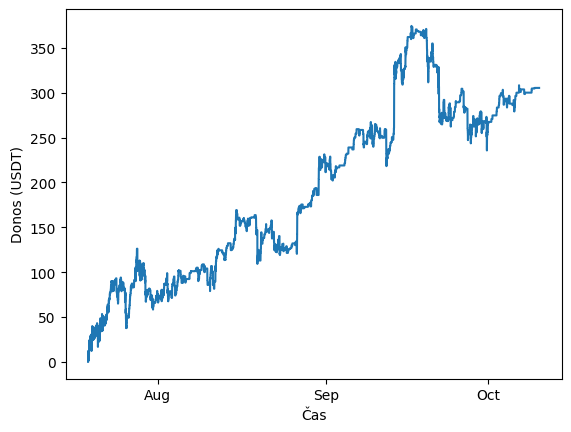

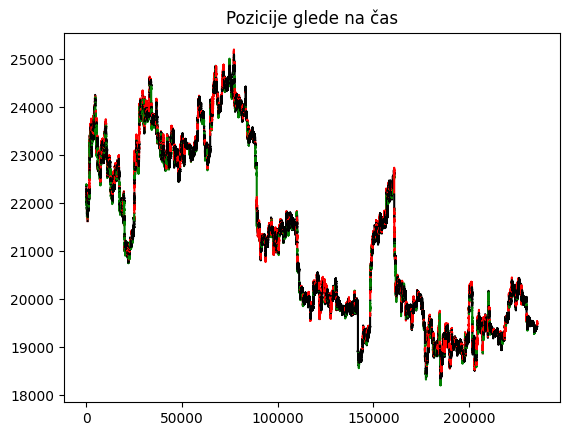

305.4161392836875

In [17]:

vstop_model_1 = np.quantile(abs(df["napoved_30s"].values), 0.95)
vstop_model_2 = np.quantile(abs(df["napoved_240s"].values), 0.95)
izstop_model_1 = np.quantile(abs(df["napoved_30s"].values), 0.75)
izstop_model_2 = np.quantile(abs(df["napoved_240s"].values), 0.75)

simulacija(vstop_model_1,vstop_model_2,izstop_model_1,izstop_model_2,0,test_start_index,True)

Ker strategija reagira le na napovedi z večjo verjetnostjo, več nimamo katastrofalne izgube. Vendar je očitno, da moramo parametre optimizirati.

In [18]:
rezultati_GA_ucni = []
rezultati_GA_testni = []

rezultati_GS_ucni = []
rezultati_GS_testni = []

def shrani_rezultat_GA(ucni, testni):
    rezultati_GA_ucni.append(ucni)
    rezultati_GA_testni.append(testni)

def shrani_rezultat_GS(ucni, testni):
    rezultati_GS_ucni.append(ucni)
    rezultati_GS_testni.append(testni)

shrani = shrani_rezultat_GA

In [19]:
def testiraj_parametre(parametri, ucna_start_index, test_start_index, shranjuj = True, narisi_graf = False, vrni_testno = False, ignoriraj_testno = False):

    ucni_df = df.iloc[ucna_start_index:test_start_index]

    #parametri so vrednosti [0,1], ki jih uporabljamo za kvantile distribucije
    vstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), parametri[0])
    vstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), parametri[1])
    izstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), parametri[2])
    izstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), parametri[3])

    if narisi_graf:
        plt.title('Učna množica (simulacija)')
        plt.xlabel('Čas')
        plt.ylabel('Donos')
    donos_ucni = simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, ucna_start_index, test_start_index, narisi_graf)
    if not ignoriraj_testno:
        if narisi_graf:
            plt.title('Testna množica (simulacija)')
            plt.xlabel('Čas')
            plt.ylabel('Donos')
        donos_testni = simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, test_start_index, -1, narisi_graf)
    if shranjuj:
        shrani(donos_ucni, donos_testni)
    if vrni_testno:
        #negativno zato ker GA modul minimizira funkcijo
        return -donos_testni
    else:
        #negativno zato ker GA modul minimizira funkcijo
        return -donos_ucni


Izvedemo optimizacijo strategije na učni množici z uporabo genetskega algoritma (50 generacij s populacijo 100)

In [20]:
GA_parametri = {'population_size':100,
                'max_num_iteration': 50,
                'mutation_probability':0.4,
                'elit_ratio': 0.01,
                'crossover_probability': 0.5,
                'crossover_type':"uniform",
                'parents_portion': 0.3,
                'max_iteration_without_improv':100}

#štirje parametri, vsi v območju [0,1]
intervali = np.array([[0,1]]*4)


def opt_funkcija(parametri):
    return testiraj_parametre(parametri, ucna_start_index, test_start_index)


genetski_algoritem = ga(function=opt_funkcija, dimension=4,variable_type='real',variable_boundaries=intervali, algorithm_parameters=GA_parametri, function_timeout=100, convergence_curve=False)

genetski_algoritem.run()

 The best solution found:                                                                           
 [0.69057249 0.70388858 0.43159335 0.91807382]

 Objective function:
 -777.7286553373375


Poglejmo si rezultat simulacije za učno množico po optimizaciji z GA.

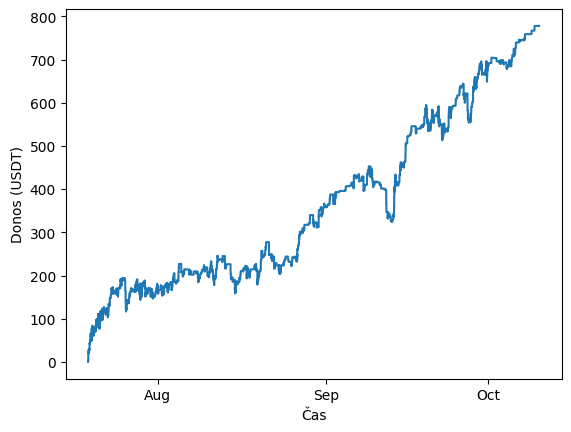

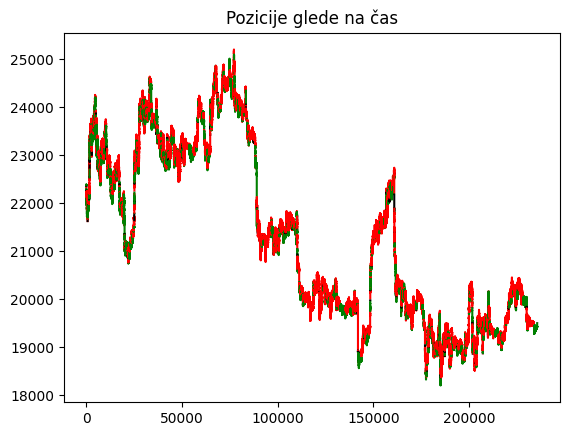

777.7286553373375

In [21]:
najboljsi_parametri = genetski_algoritem.output_dict["variable"]
ucni_df = df.iloc[0:test_start_index]
#parametri so vrednosti [0,1], ki jih uporabljamo za kvantile učne distribucije
vstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), najboljsi_parametri[0])
vstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), najboljsi_parametri[1])
izstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), najboljsi_parametri[2])
izstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), najboljsi_parametri[3])

simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, 0, test_start_index, True)

Preverimo efektivnost uporabe genetskega algoritma tako, da naredimo primerjavo z grobo silo . Poskusimo poiskati najbojlše parametre na podlagi naključnega iskanja nad učno množico, z istim številom simulacij.

In [22]:
shrani = shrani_rezultat_GS

najbojsi = None
najboljsi_zgodovina = []
for i in range(len(rezultati_GA_ucni)):
    parametri = []
    for j in range(4):
        parametri.append(random.random())
    testiraj_parametre(parametri, ucna_start_index, test_start_index)


Definirajmo funkcijo, ki izriše graf najbojlšega rezultata glede na število poskusov

In [23]:
def prikazi_zgodovina_najboljsi(zgodovina_rezultati, ime):
    najbojsi = None
    najboljsi_zgodovina = []
    for i in range(len(zgodovina_rezultati)):
        trenutni_rezultat = zgodovina_rezultati[i]
        if najbojsi is None:
            najbojsi = trenutni_rezultat
        else:
            if trenutni_rezultat > najbojsi:
                najbojsi = trenutni_rezultat
        najboljsi_zgodovina.append(najbojsi)
    plt.plot(najboljsi_zgodovina, label=ime)

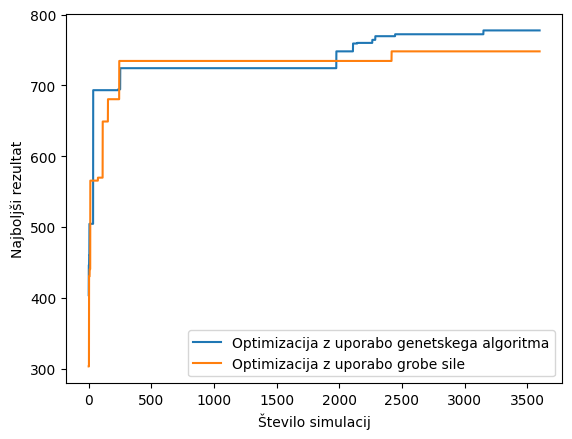

In [24]:
prikazi_zgodovina_najboljsi(rezultati_GA_ucni, ime="Optimizacija z uporabo genetskega algoritma")
prikazi_zgodovina_najboljsi(rezultati_GS_ucni, ime="Optimizacija z uporabo grobe sile")
plt.xlabel('Število simulacij')
plt.ylabel('Najboljši rezultat')
plt.legend()
plt.show()

In [25]:
def sortiraj_skupaj(prva, druga):
    #sortirali bomo glede na prvo
    zipped_lists = list(zip(prva, druga))
    zipped_lists = sorted(zipped_lists, key=lambda x: x[0])
    sortirana_prva, sortirana_druga = zip(*zipped_lists)
    return sortirana_prva, sortirana_druga


In [26]:
rezultati_GA_ucni_sortirani, rezultati_GA_testni_sortirani = sortiraj_skupaj(rezultati_GA_ucni, rezultati_GA_testni)
rezultati_GS_ucni_sortirani, rezultati_GS_testni_sortirani = sortiraj_skupaj(rezultati_GS_ucni, rezultati_GS_testni)

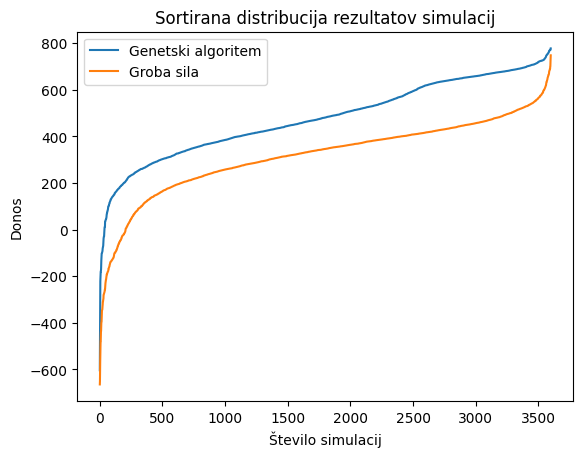

In [27]:
plt.plot(rezultati_GA_ucni_sortirani, label = "Genetski algoritem")
plt.plot(rezultati_GS_ucni_sortirani, label = "Groba sila")
plt.legend()
plt.xlabel('Število simulacij')
plt.ylabel('Donos')
plt.title('Sortirana distribucija rezultatov simulacij')
plt.show()

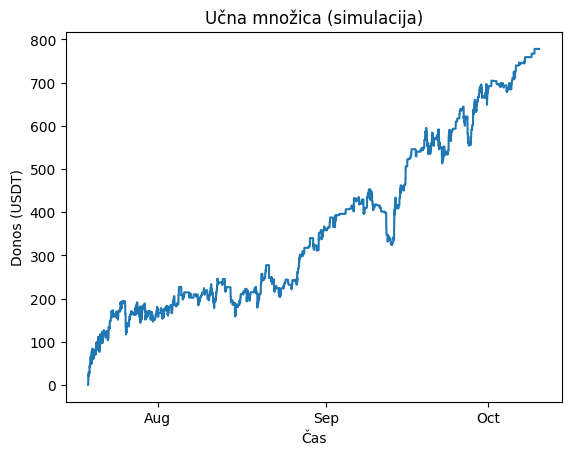

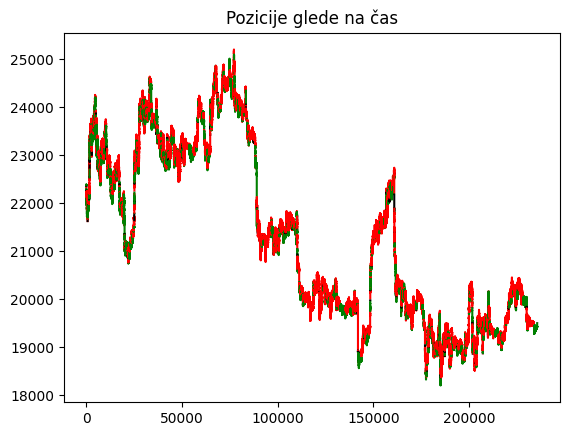

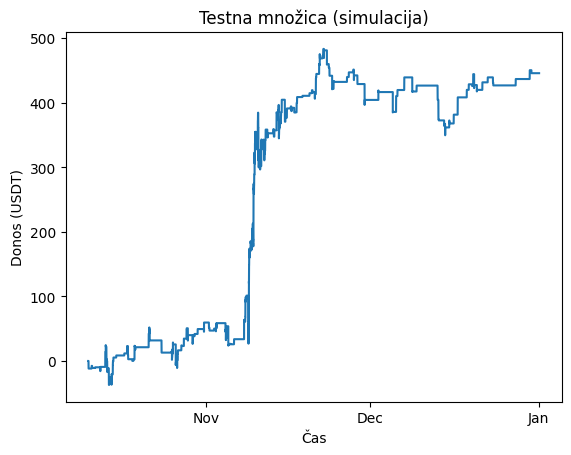

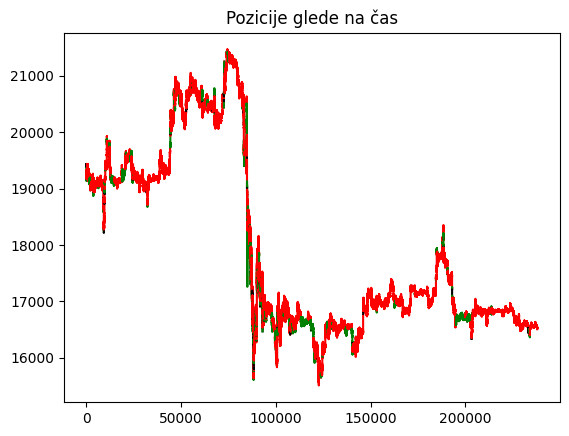

-777.7286553373375

In [28]:
testiraj_parametre(najboljsi_parametri, ucna_start_index, test_start_index, shranjuj=False, narisi_graf=True)

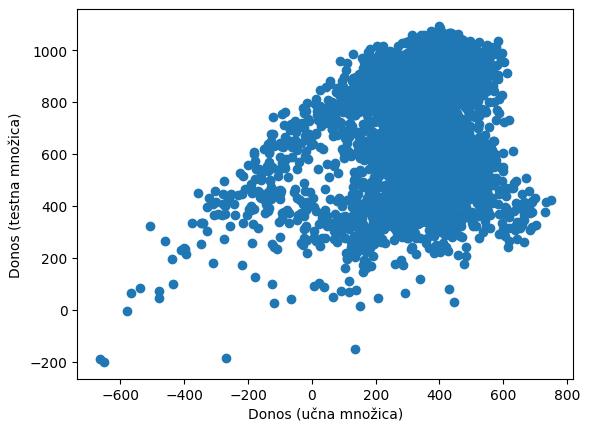

In [29]:
plt.plot(rezultati_GS_ucni_sortirani, rezultati_GS_testni_sortirani, 'o')
plt.xlabel('Donos (učna množica)')
plt.ylabel('Donos (testna množica)')
#plt.title('Rezultati simulacij (sortirano po učnih)')
plt.show()


Poskusimo zamenjati učno in testno, da dobimo občutek za koliko se prekomerno prilagodi strategija na učno množico. Torej, pričakujemo, da bomo dosegli boljši rezultat na množici, ki je prej bila testna in bo sedaj učna.

In [30]:
#resetiramo spremenljivke 
rezultati_GA_ucni = []
rezultati_GA_testni = []
shrani = shrani_rezultat_GA

In [31]:
def zamenjano(parametri):
    return testiraj_parametre(parametri, ucna_start_index, test_start_index, True, False, vrni_testno =True)

genetski_algoritem = ga(function=zamenjano,dimension=4,variable_type='real',variable_boundaries=intervali, algorithm_parameters=GA_parametri, function_timeout=100, convergence_curve=False)
genetski_algoritem.run()
najboljsi_parametri_zamenjano = genetski_algoritem.output_dict["variable"]

 The best solution found:                                                                           
 [0.11221542 0.51738995 0.28179492 0.61926406]

 Objective function:
 -1178.0265886307454


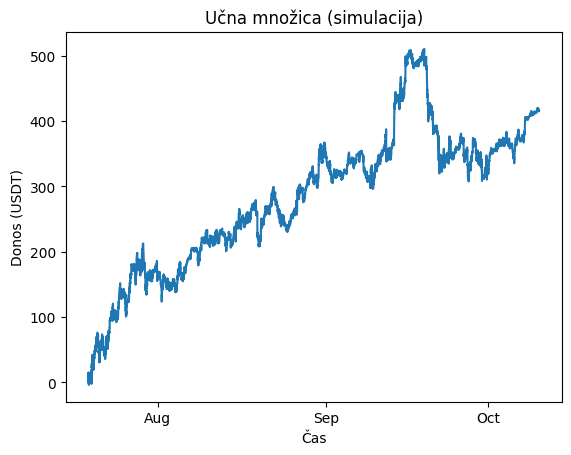

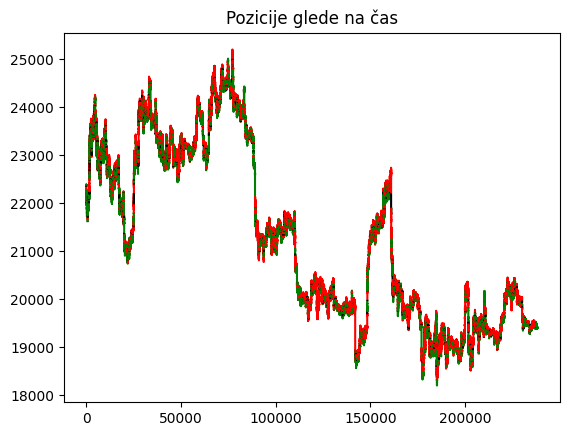

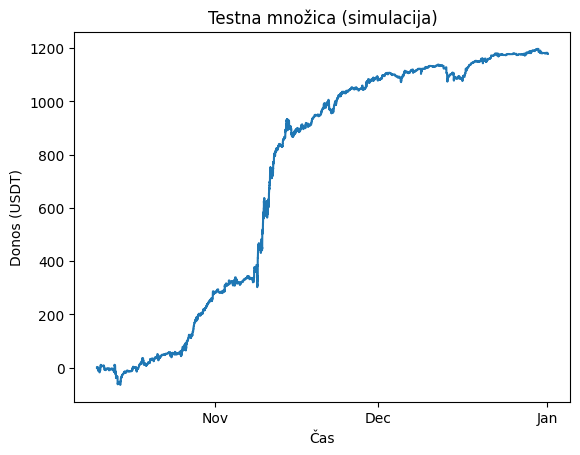

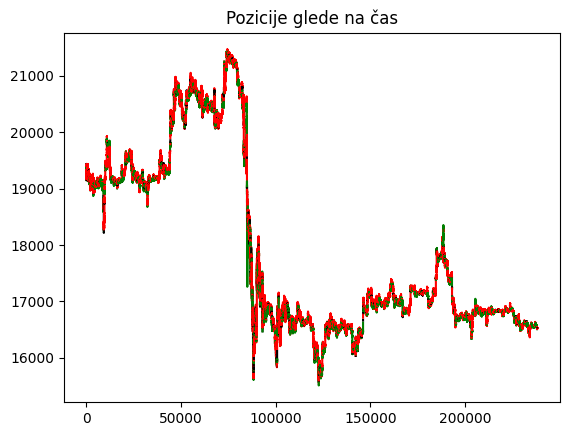

-415.5418803563485

In [32]:
testiraj_parametre(najboljsi_parametri_zamenjano, ucna_start_index, test_start_index, shranjuj=False, narisi_graf=True)

Primerjajmo grafe obeh množic; ko je učna in ko je testna

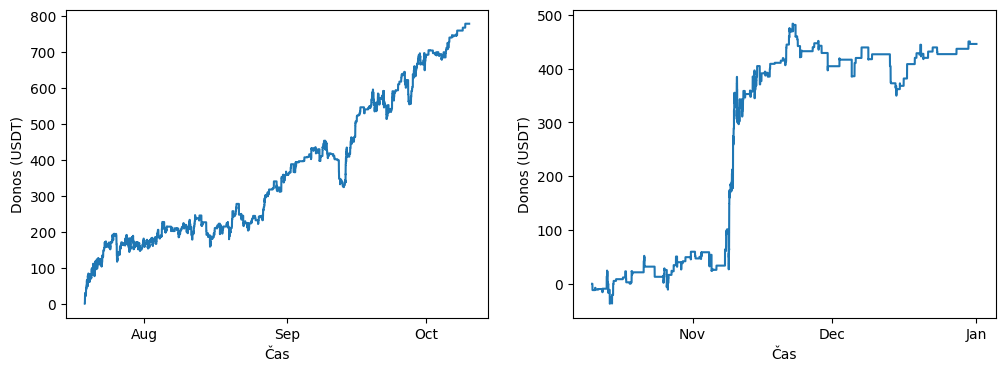

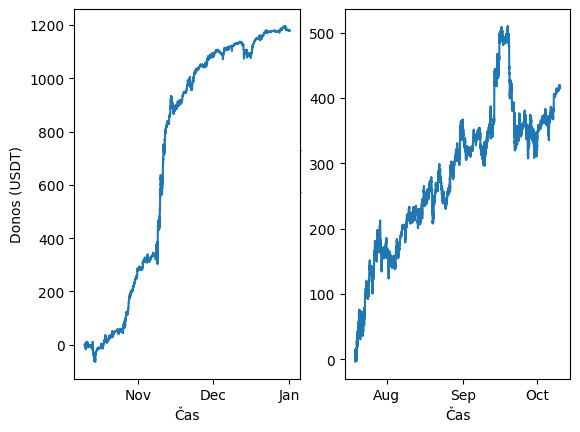

In [34]:

import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsOrig)

plt.figure(figsize=(12,4))

ucni_df = df.iloc[0:test_start_index]
vstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), najboljsi_parametri[0])
vstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), najboljsi_parametri[1])
izstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), najboljsi_parametri[2])
izstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), najboljsi_parametri[3])
plt.subplot(121)
simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, 0, test_start_index, True, show_graf=False, graf_pozicij = False)

plt.subplot(122)
simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, test_start_index, -1, True, show_graf=False, graf_pozicij = False)
plt.show()
vstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), najboljsi_parametri_zamenjano[0])
vstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), najboljsi_parametri_zamenjano[1])
izstop_model_1 = np.quantile(abs(ucni_df["napoved_30s"].values), najboljsi_parametri_zamenjano[2])
izstop_model_2 = np.quantile(abs(ucni_df["napoved_240s"].values), najboljsi_parametri_zamenjano[3])
plt.subplot(122)
simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, 0, test_start_index, True, show_graf=False, graf_pozicij = False)
plt.subplot(121)
simulacija(vstop_model_1, vstop_model_2, izstop_model_1, izstop_model_2, test_start_index, -1, True, show_graf=False, graf_pozicij = False)
plt.show()

Preverimo vplv velikosti učne množice na uspeh testne

In [34]:
ucna_delezi = np.arange(0.25, 1, 0.025) #[0.25, 0.275 ... 1]
koncni_rezultati_test = []
GA_parametri["max_num_iteration"] = 50
GA_parametri["population_size"] = 100

for delez in ucna_delezi:

    trenutni_ucna_start_index = int(test_start_index - int((test_start_index - ucna_start_index)*delez))

    def opt_funkcija(parametri):
        return testiraj_parametre(parametri, trenutni_ucna_start_index, test_start_index, False, False, False, ignoriraj_testno=True)

    print("Dolžina učne:", str(int(delez*100)) + "% (" + str(test_start_index - trenutni_ucna_start_index) + ")")

    #da so si vsi poskusi čim bolj podobni
    random.seed(0)
    np.random.seed(0)

    genetski_algoritem = ga(function=opt_funkcija,dimension=4,variable_type='real',variable_boundaries=intervali, algorithm_parameters=GA_parametri, function_timeout=100, convergence_curve=False)
    genetski_algoritem.run()

    rezultat_test = -testiraj_parametre(genetski_algoritem.output_dict["variable"],trenutni_ucna_start_index, test_start_index, False, False, vrni_testno=True)
    koncni_rezultati_test.append(rezultat_test)

    print(" Rezultat testne:", rezultat_test)



Dolžina učne: 25% (59511)
 The best solution found:                                                                           
 [0.50505228 0.4863973  0.67150637 0.92501063]

 Objective function:
 -259.3860387898914
 Rezultat testne: 410.25177543690404
Dolžina učne: 27% (65462)
 The best solution found:                                                                           
 [0.84278306 0.79610195 0.63967589 0.9279953 ]

 Objective function:
 -308.5297913204934
 Rezultat testne: 397.17930698951506
Dolžina učne: 30% (71414)
 The best solution found:                                                                           
 [0.06047242 0.66461133 0.75968003 0.92954228]

 Objective function:
 -368.60592766047097
 Rezultat testne: 341.0297252886573
Dolžina učne: 32% (77365)
 The best solution found:                                                                           
 [0.50456811 0.47608145 0.59252175 0.9207829 ]

 Objective function:
 -507.93582297298826
 Rezultat testne: 414.49

In [35]:
def narisi_graf_korelacije(X, Y):
    plt.plot(X, Y, 'o')
    coefficients = np.polyfit(X, Y, 1)
    polynomial = np.poly1d(coefficients)
    line_x_values = np.array([min(X), max(X)])
    line_y_values = polynomial(line_x_values)
    plt.plot(line_x_values, line_y_values)

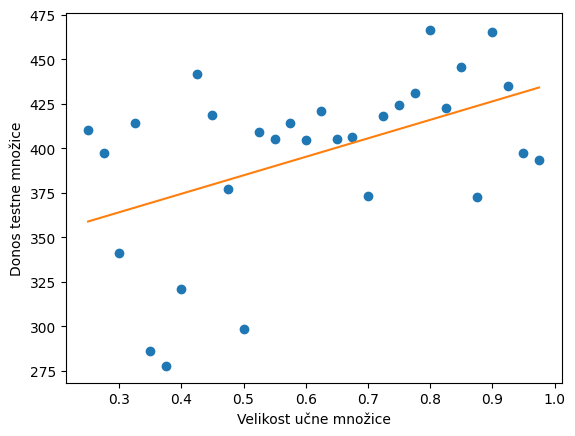

In [36]:
plt.xlabel('Velikost učne množice')
plt.ylabel('Donos testne množice')
narisi_graf_korelacije(ucna_delezi, koncni_rezultati_test)
plt.show()

Želimo eksperimentirati s strategijo križanja drsečih povprečij (angl. moving average crossover). Lahko uporabimo večjo učno množico cen, saj ne potrebujemo testnih napovedi nevronskih mrež.

In [37]:
with open("cene_vecji.p", "rb") as rb:
    cene_df = pickle.load(rb)

In [38]:
cene_df.head()

,t,cena
0,1643892885000,36567.816272
1,1643892915000,36585.887929
2,1643892945000,36602.210118
3,1643892975000,36605.924970
4,1643893005000,36609.796627


In [39]:
cene_df = cene_df.sort_values(by='t')

In [40]:
cene_df = cene_df.dropna()

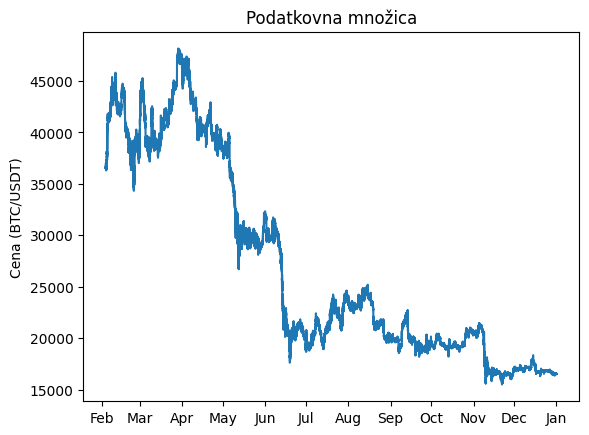

In [41]:
narisi_graf_s_casom(cene_df['t'].values, cene_df['cena'].values)
plt.title("Podatkovna množica")
plt.ylabel('Cena (BTC/USDT)')
plt.show()

In [42]:
max_dolzina = 1000

test_start_index_MA = df[df['t'] > df.loc[test_start_index, "t"]].index[0]


rezultati_MA_ucni = []
rezultati_MA_testni = []

def shrani_rezultat_MA(ucni, testni):
    rezultati_MA_ucni.append(ucni)
    rezultati_MA_testni.append(testni)

In [43]:
test_start_index_MA = cene_df[cene_df['t'] > df.loc[test_start_index, "t"]].index[0]

In [44]:
def simulacija_MA(zacetek, konec, narisi_graf = False):
  
  cas = []
  zgodovina = []
  donos = 0  
  pozicija = POZICIJA_BREZ
  prejsnji_t = 0

  vstopna_cena = None

  #zankamo v zaporedju skozi cene in napovedi
  for row in cene_df.iloc[zacetek + max_dolzina :konec].itertuples(index=False):
    t = row.t
    cena = row.cena
    MA_krajsi = row.krajsi
    MA_daljsi = row.daljsi

    #če je prekinitev v podatkih, ignoriramo in resetiramo trenutno pozicijo
    if t - prejsnji_t != 30000 and t != 0:
      pozicija = POZICIJA_BREZ
    prejsnji_t = t

    if narisi_graf:
      zgodovina.append(donos)
      cas.append(t)

    #strategija je brez posicije samo na začetku ali pa po prekinitvi, zato ne računamo stroška trgovanja
    if pozicija == POZICIJA_BREZ:
      if MA_krajsi > MA_daljsi:
        pozicija = POZICIJA_DOLGO
      else:
        pozicija = POZICIJA_KRATKO
      vstopna_cena = cena

    elif pozicija == POZICIJA_DOLGO:
      if MA_krajsi < MA_daljsi:
        pozicija = POZICIJA_KRATKO
        razlika = (cena - vstopna_cena)/vstopna_cena
        donos = donos + velikost_pozicije * (razlika - stroski*2)
        vstopna_cena = cena

    else: # pozicija == POZICIJA:KRATKO
      if MA_krajsi > MA_daljsi:
        pozicija = POZICIJA_DOLGO
        razlika = (vstopna_cena - cena)/vstopna_cena
        donos = donos + velikost_pozicije * (razlika - stroski*2)
        vstopna_cena = cena
  if narisi_graf:
    narisi_graf_s_casom(cas, zgodovina)
    plt.show()
  return donos

Prejšnjo funkcijo testiranja prilagodimo

In [45]:
def testiraj_parametre_MA(parametri, shranjuj = True, narisi_graf = False, vrni_testno = False):

    krajsi = int(parametri[0])
    daljsi = int(parametri[1])
    if krajsi > daljsi:
        return 99999

    cene_df["krajsi"] = cene_df['cena'].rolling(krajsi).mean()
    cene_df["daljsi"]  = cene_df['cena'].rolling(daljsi).mean()

    if narisi_graf:
        plt.title('Učna množica (simulacija)')
        plt.xlabel('Čas')
        plt.ylabel('Donos (USDT)')
    donos_ucni = simulacija_MA(0, test_start_index_MA, narisi_graf)
    if narisi_graf:
        plt.title('Testna množica (simulacija)')
        plt.xlabel('Čas')
        plt.ylabel('Donos (USDT)')
    donos_testni = simulacija_MA(test_start_index_MA, -1, narisi_graf)
    if shranjuj:
        shrani_rezultat_MA(donos_ucni, donos_testni)
    if vrni_testno:
        return -donos_testni
    else:
        return -donos_ucni

In [46]:
cene_df.head()

,t,cena
0,1643892885000,36567.816272
1,1643892915000,36585.887929
2,1643892945000,36602.210118
3,1643892975000,36605.924970
4,1643893005000,36609.796627


In [47]:

GA_parametri = {'max_num_iteration': 40,
                'population_size':75,
                'mutation_probability':0.4,
                'elit_ratio': 0.01,
                'crossover_probability': 0.5,
                'parents_portion': 0.3,
                'crossover_type':'uniform',
                'max_iteration_without_improv':100}


intervali_MA = np.array([[10,240], [20, max_dolzina]])

genetski_algoritem = ga(function=testiraj_parametre_MA,dimension=2,variable_type='real',variable_boundaries=intervali_MA, algorithm_parameters=GA_parametri, function_timeout=100, convergence_curve=False)

genetski_algoritem.run()

 The best solution found:                                                                           
 [230.81932172 456.8788649 ]

 Objective function:
 -665.3642348537512


Poglejmo si rezultat optimalne strategije križanja drsečih povprečij

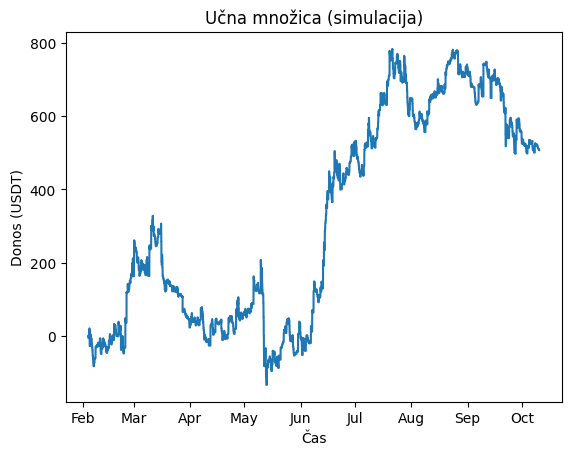

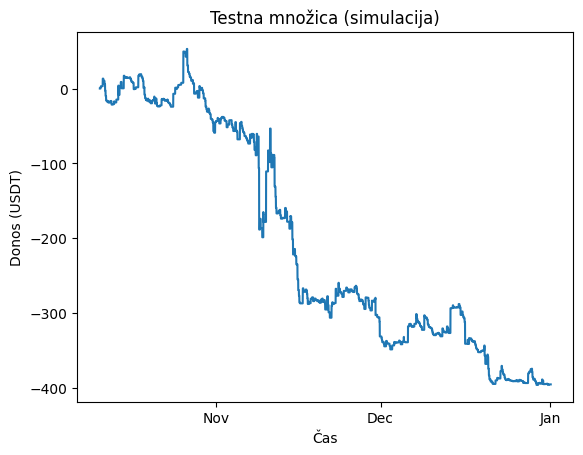

-507.04345980600436

In [48]:
testiraj_parametre_MA([230, 511], False, True, False)

Poskusimo našo strategijo optimizirati za trg, ki ima večje stroške (0.037%)

In [49]:
rezultati_GA_ucni = []
rezultati_GA_testni = []
shrani = shrani_rezultat_GA

GA_parametri["max_num_iteration"] = 30
GA_parametri["population_size"] = 50

def opt_funkcija(parametri):
    return testiraj_parametre(parametri, ucna_start_index, test_start_index)

stroski = 0.00037

genetski_algoritem = ga(function=opt_funkcija, dimension=4,variable_type='real',variable_boundaries=intervali, algorithm_parameters=GA_parametri, function_timeout=100, convergence_curve=False)
genetski_algoritem.run()


 The best solution found:                                                                           
 [0.6055378  0.99869301 0.28923045 0.94451892]

 Objective function:
 -157.12445704394275


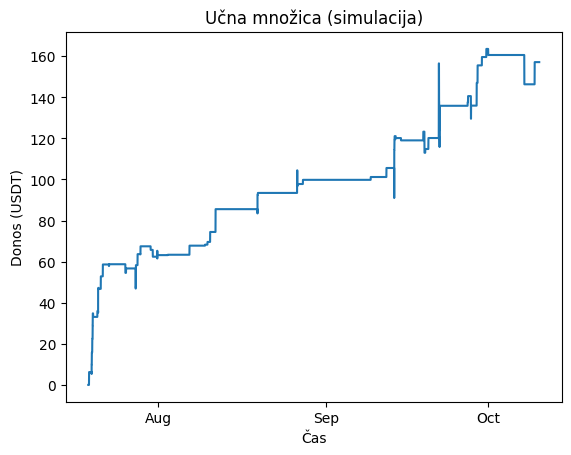

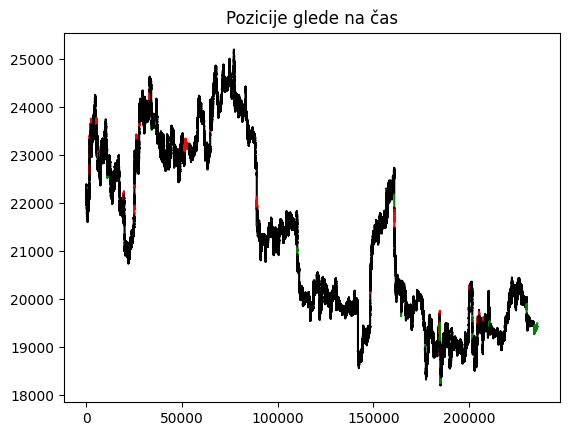

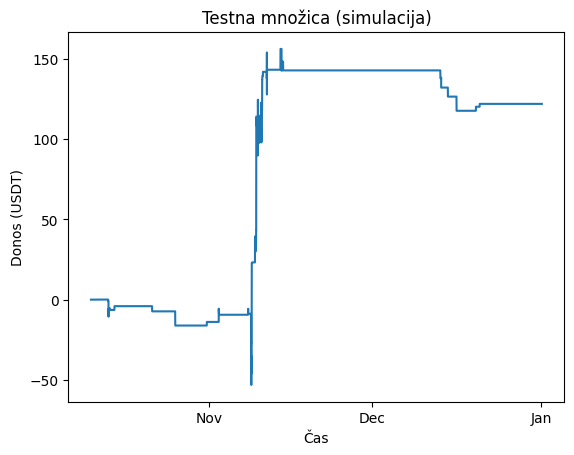

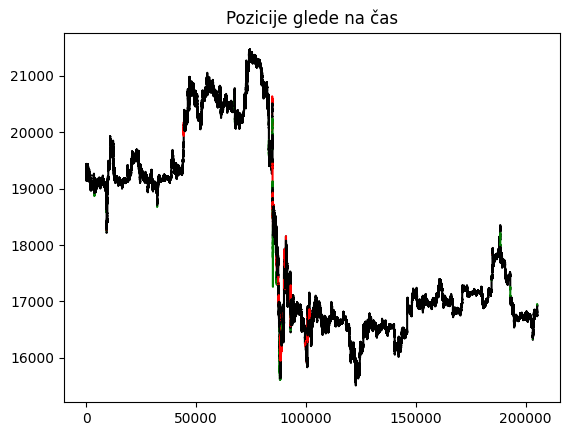

-157.12445704394275

In [50]:
testiraj_parametre(genetski_algoritem.output_dict["variable"], ucna_start_index, test_start_index, False, narisi_graf=True)